In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

osu! path: C:\Users\niooi\AppData\Roaming/../Local/osu!
pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [ ]:
obj_dataset = dataset.replay_mapping_from_cache(400)

In [ ]:
obj_dataset

In [ ]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

In [ ]:
input = input_data
output = output_data

In [ ]:
input[0:500]

In [ ]:
output[0:500]

In [ ]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

In [ ]:
ys.shape

In [ ]:
# save dataset so we have it later

# os.makedirs(f'.datasets', exist_ok=True)
# 
np.save(f'.datasets/xs.npy', xs)
np.save(f'.datasets/ys.npy', ys)

In [2]:
# reload from saved

xs = np.load(f'.datasets/xs_5000_07-21_23-28-07.npy')
ys = np.load(f'.datasets/ys_5000_07-21_23-28-07.npy')

# xs = np.load(f'.datasets/xs_142_07-21_21-50-55.npy')
# ys = np.load(f'.datasets/ys_142_07-21_21-50-55.npy')

In [3]:
# tys = ys.reshape(ys.shape[0] * ys.shape[1], ys.shape[2])
# for frame in tys:
#     if np.isinf(frame).any():
#         print(frame)

In [7]:
import torch

BATCH_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [113]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

0

In [114]:
from osu.rnn import OsuReplayRNN

In [115]:
print("Creating RNN model...")
rnn = OsuReplayRNN(batch_size=BATCH_SIZE, noise_std=0.06)
rnn.load_data(xs, ys)

Creating RNN model...
Position model compiled with torch.compile
RNN Model initialized on cuda (noise_std=0.06)
Position model parameters: 227650
Data loaded: 14082 training samples, 3521 test samples (position only)


Epoch 1/8 (Train): 100%|██████████| 111/111 [00:13<00:00,  8.30it/s]


Epoch 1/8, Train: 0.0011, Test: 0.0013


Epoch 2/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.55it/s]


Epoch 2/8, Train: 0.0011, Test: 0.0013


Epoch 3/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.55it/s]


Epoch 3/8, Train: 0.0011, Test: 0.0012


Epoch 4/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.78it/s]


Epoch 4/8, Train: 0.0011, Test: 0.0011


Epoch 5/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.68it/s]


Epoch 5/8, Train: 0.0011, Test: 0.0012


Epoch 6/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.63it/s]


Epoch 6/8, Train: 0.0011, Test: 0.0011


Epoch 7/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.74it/s]


Epoch 7/8, Train: 0.0011, Test: 0.0011


Epoch 8/8 (Train): 100%|██████████| 111/111 [00:12<00:00,  8.72it/s]


Epoch 8/8, Train: 0.0011, Test: 0.0010


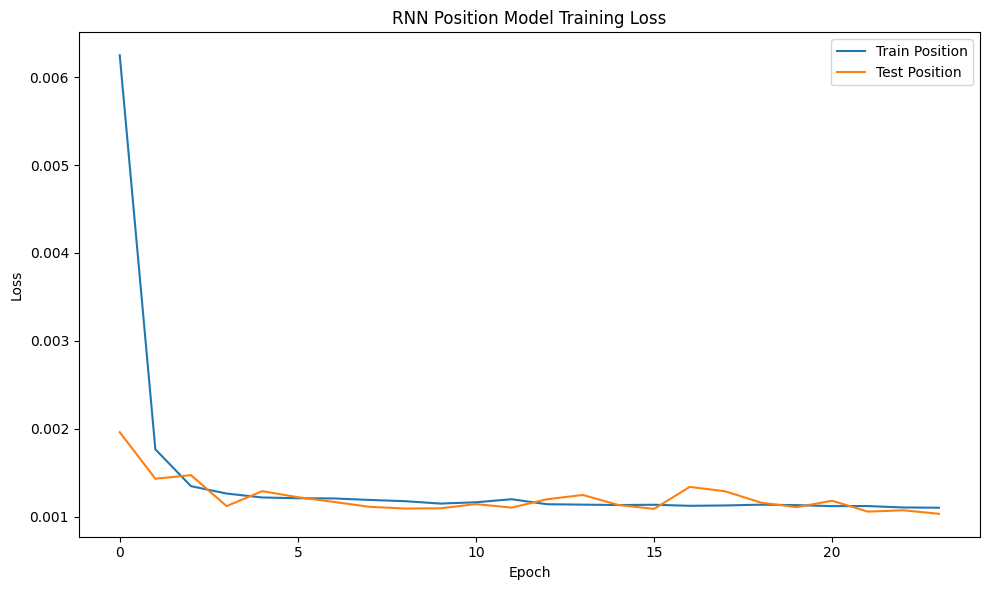

RNN model saved to .trained/rnn_2025-07-22_19-05-41.pt


In [129]:
RNN_EPOCHS = 8

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [51]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

del rnn

NameError: name 'rnn' is not defined

In [52]:
from osu.gan import OsuReplayGAN

In [53]:
print("Creating GAN model...")
gan = OsuReplayGAN(batch_size=BATCH_SIZE)
gan.load_data(xs, ys)

Creating GAN model...
Using LSTM discriminator
GAN models compiled..
GAN Models initialized on cuda
Generator parameters: 244034
Discriminator parameters: 55361
Real positions: tensor([-0.2639, -0.2641, -0.2645, -0.2640, -0.2649], device='cuda:0')
Generated positions: tensor([-0.2639, -0.2641, -0.2645, -0.2641, -0.2649], device='cuda:0')
Random positions: tensor([-0.2638, -0.2641, -0.2645, -0.2640, -0.2649], device='cuda:0')
Zero positions: tensor([-0.2639, -0.2641, -0.2645, -0.2641, -0.2649], device='cuda:0')
Output range: [-0.264933, -0.263841]
Output variance: 0.000000
Real vs Generated gap: 0.000024 (smaller = generator fooling discriminator)
Data loaded: 14082 training samples, 3521 test samples (position only)


Epoch 1/2 (GAN): 100%|██████████| 111/111 [03:42<00:00,  2.00s/it]


Epoch 1/2, Gen: 0.6977 (Pos: 0.0040), Disc: 0.6934


Epoch 2/2 (GAN): 100%|██████████| 111/111 [03:44<00:00,  2.02s/it]


Epoch 2/2, Gen: 0.6998 (Pos: 0.0034), Disc: 0.6934
Real positions: tensor([-0.0067, -0.0176, -0.0046, -0.0247, -0.0096], device='cuda:0')
Generated positions: tensor([-0.0067, -0.0175, -0.0046, -0.0247, -0.0095], device='cuda:0')
Random positions: tensor([-0.0069, -0.0174, -0.0049, -0.0248, -0.0099], device='cuda:0')
Zero positions: tensor([-0.0068, -0.0174, -0.0049, -0.0247, -0.0097], device='cuda:0')
Output range: [-0.024833, -0.004579]
Output variance: 0.000058
Real vs Generated gap: 0.000050 (smaller = generator fooling discriminator)
GAN models saved to .trained/gan_2025-07-22_15-05-52.pt


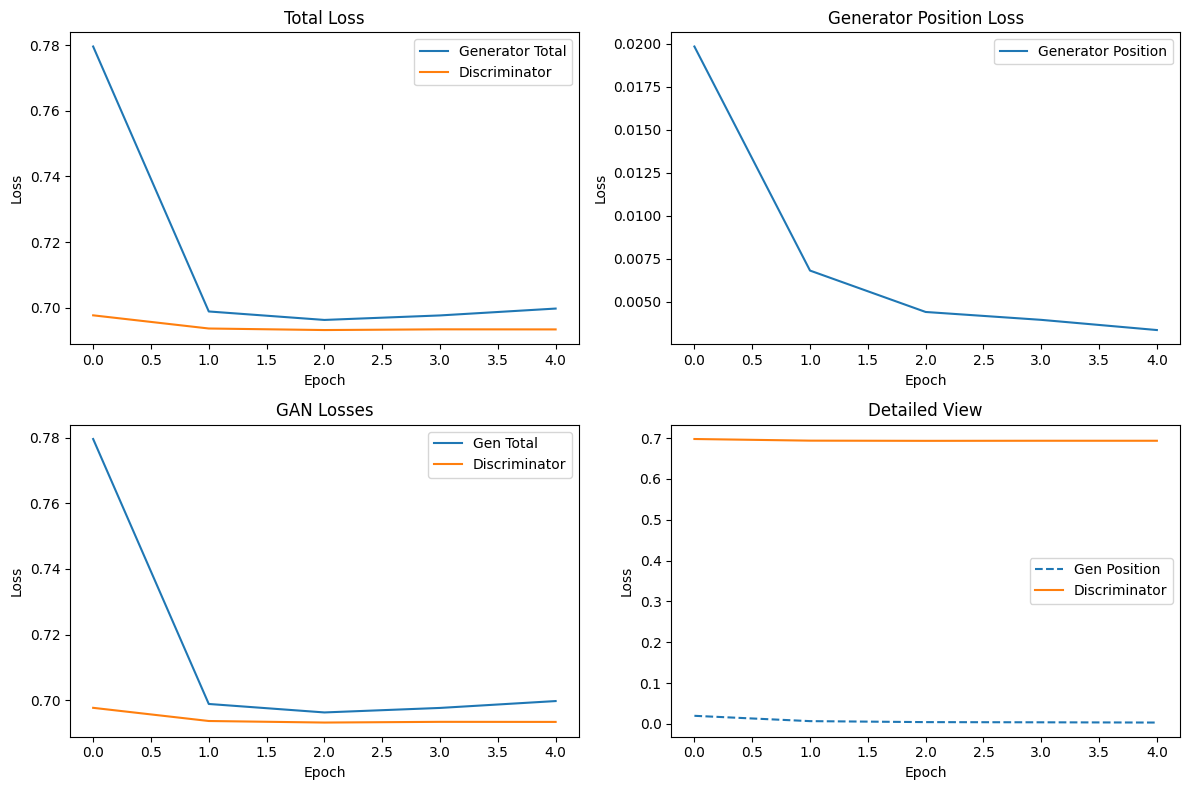

In [55]:
GAN_EPOCHS = 2

# Train the GAN
for i in range(1):
    gan.train(epochs=GAN_EPOCHS)
    gan.check_discriminator_sanity()
    gan.save()
    
gan.plot_losses()

In [23]:
gan.test_discriminator_capability()

Real positions: tensor([-0.0496, -0.0089,  0.0656, -0.0040, -0.0034], device='cuda:0')
Random positions: tensor([ 8.6722, 14.9161, 18.8236,  6.2834, 12.5871], device='cuda:0')
Zero positions: tensor([-0.0163, -0.0041, -0.0938, -0.0904, -0.0167], device='cuda:0')


In [3]:
from osu.vae import OsuReplayVAE

In [4]:
vae = OsuReplayVAE(batch_size=BATCH_SIZE)

vae.load_data(xs, ys)

NameError: name 'BATCH_SIZE' is not defined

In [ ]:

VAE_EPOCHS = 15

for i in range(45):
    vae.train(VAE_EPOCHS)
    vae.save()
    
vae.plot_losses()

In [ ]:
from osu.keys import OsuKeyModel

In [ ]:
print("Creating keypress model...")
keys = OsuKeyModel(batch_size=BATCH_SIZE)
keys.load_data(xs, ys)

In [ ]:
KEYS_EPOCHS = 12

# Train the key model
for i in range(12):
    keys.train(epochs=KEYS_EPOCHS)
    keys.save()
    
keys.plot_losses()

In [ ]:
del keys

In [131]:
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.dataset as dataset

test_name = 'ringyou'
test_mods = Mods.DOUBLE_TIME
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


x    y  time_until_click  is_slider  is_spinner    cs  \
chunk frame                                                                 
0     0     -0.236328  0.0             0.380        1.0         0.0  0.42   
      1     -0.236328  0.0             0.356        1.0         0.0  0.42   
      2     -0.236328  0.0             0.332        1.0         0.0  0.42   
      3     -0.236328  0.0             0.308        1.0         0.0  0.42   
      4     -0.236328  0.0             0.284        1.0         0.0  0.42   
...               ...  ...               ...        ...         ...   ...   
3     2043   0.000000  0.0             0.000        0.0         0.0  0.00   
      2044   0.000000  0.0             0.000        0.0         0.0  0.00   
      2045   0.000000  0.0             0.000        0.0         0.0  0.00   
      2046   0.000000  0.0             0.000        0.0         0.0  0.00   
      2047   0.000000  0.0             0.000        0.0         0.0  0.00   

             slider_speed  slider_len  
chunk frame                            
0     0             0.258        0.05  
      1             0.258        0.05  
      2             0.258        0.05  
      3             0.258        0.05  
      4             0.258        0.05  
...                   ...         ...  
3     2043          0.000        0.00  
      2044          0.000        0.00  
      2045          0.000        0.00  
      2046          0.000        0.00  
      2047          0.000        0.00  

[8192 rows x 8 columns]

In [132]:
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

In [133]:
with torch.no_grad():
    # Use generator for inference
    replay_data = rnn.generate(data)
    
replay_data = np.concatenate(replay_data)
replay_data = np.pad(replay_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

Generated replay data shape: (8192, 4)
Saved to .generated\ringyou.npy


In [134]:
data[:500]

tensor([[[-0.2363,  0.0000,  0.3800,  ...,  0.4200,  0.2580,  0.0500],
         [-0.2363,  0.0000,  0.3560,  ...,  0.4200,  0.2580,  0.0500],
         [-0.2363,  0.0000,  0.3320,  ...,  0.4200,  0.2580,  0.0500],
         ...,
         [ 0.2910,  0.0755,  0.0213,  ...,  0.4200,  0.0000,  0.0000],
         [-0.2969,  0.1849,  0.1133,  ...,  0.4200,  0.0000,  0.0000],
         [-0.2969,  0.1849,  0.0893,  ...,  0.4200,  0.0000,  0.0000]],

        [[-0.2969,  0.1849,  0.0653,  ...,  0.4200,  0.0000,  0.0000],
         [-0.2969,  0.1849,  0.0413,  ...,  0.4200,  0.0000,  0.0000],
         [-0.2969,  0.1849,  0.0173,  ...,  0.4200,  0.0000,  0.0000],
         ...,
         [ 0.3203,  0.1458,  0.0553,  ...,  0.4200,  0.7740,  0.1500],
         [ 0.3203,  0.1458,  0.0313,  ...,  0.4200,  0.7740,  0.1500],
         [ 0.3203,  0.1458,  0.0073,  ...,  0.4200,  0.7740,  0.1500]],

        [[ 0.3203,  0.1120,  0.0000,  ...,  0.4200,  0.7740,  0.1500],
         [ 0.3242,  0.0651,  0.0000,  ...,  0

In [135]:
replay_data[:500]

array([[-0.05669861, -0.01003247,  0.        ,  0.        ],
       [-0.07373986, -0.00584773,  0.        ,  0.        ],
       [-0.08680908, -0.00358545,  0.        ,  0.        ],
       ...,
       [-0.09404936,  0.03996268,  0.        ,  0.        ],
       [-0.08838032,  0.00870745,  0.        ,  0.        ],
       [-0.08174181, -0.02751468,  0.        ,  0.        ]],
      shape=(500, 4), dtype=float32)

In [136]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)